# ODS Core queries stats

#### Create and start event session to gather event:


    -- Delete old, if exists
    IF EXISTS(SELECT * FROM sys.server_event_sessions WHERE name='query hash')
        DROP EVENT SESSION [query hash] ON SERVER;
 
    -- Create new
    CREATE EVENT SESSION [query hash] ON SERVER
    ADD EVENT sqlserver.module_end(
        ACTION(package0.collect_system_time,
               sqlserver.nt_username,
               sqlserver.client_hostname,
               sqlserver.database_name,
               sqlserver.query_hash,
               sqlserver.query_plan_hash)
    ),
    ADD EVENT sqlserver.sql_statement_completed(
        ACTION(package0.collect_system_time,
               sqlserver.nt_username,
               sqlserver.client_hostname,
               sqlserver.database_name,
               sqlserver.query_hash,
               sqlserver.query_plan_hash)
    )
    ADD TARGET package0.asynchronous_file_target
    (SET filename = 'K:\Extended Events\XEventSessions\query_hash.xel',
         metadatafile = 'K:\Extended Events\XEventSessions\query_hash.xem',
         max_file_size=500,
         max_rollover_files=5)
    WITH (MAX_DISPATCH_LATENCY = 5SECONDS);

#### Starting event collecting:

    ALTER EVENT SESSION [query hash] ON SERVER
    STATE = START ;

#### Stopping:

    ALTER EVENT SESSION [query hash] ON SERVER
    STATE = STOP;


#### Extract XML with data:

    SELECT xevents.event_data
    FROM sys.fn_xe_file_target_read_file
             ('K:\Extended Events\XEventSessions\query_hash*.xel',
              null, null, null)
        CROSS APPLY (select CAST(event_data as XML) as event_data) as xevents

#### Transform XML into parquet with Spark

https://github.com/rampage644/spark-sql

#### Now, use pyspark with ipython notebook for fancy data analysis

In [1]:
from pyspark.sql import SQLContext

In [2]:
ctx = SQLContext(sc)

In [3]:
data = ctx.parquetFile('srows.parquet').cache()
data.printSchema()

root
 |-- physical_reads: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- query_hash: string (nullable = true)
 |-- name: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- collect_system_time: string (nullable = true)
 |-- logical_reads: integer (nullable = true)
 |-- object_name: string (nullable = true)
 |-- last_row_count: integer (nullable = true)
 |-- object_type: string (nullable = true)
 |-- statement: string (nullable = true)
 |-- line_number: integer (nullable = true)
 |-- row_count: integer (nullable = true)
 |-- source_database_id: integer (nullable = true)
 |-- offset: integer (nullable = true)
 |-- nt_username: string (nullable = true)
 |-- offset_end: integer (nullable = true)
 |-- database_name: string (nullable = true)
 |-- cpu_time: integer (nullable = true)
 |-- client_hostname: string (nullable = true)
 |-- writes: integer (nullable = true)
 |-- query_plan_hash: string (nullable = true)
 |-- object_id: string (nullable = t

In [4]:
data.registerAsTable('srows')

In [44]:
duration = data.map(lambda x: x.duration).collect()

In [61]:
rc = data.map(lambda x: x.row_count).distinct().collect()

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

# Queries duration distribution

(array([   98663.,    20733.,   627571.,   170939.,  2331769.,  1533928.,
          344961.,   215440.,   439987.,   145945.,    96616.,   231048.,
           48851.,    30549.,    16321.,     9584.,     8201.,    16184.,
            4393.,     3897.]),
 array([   0.,    6.,   12.,   18.,   24.,   30.,   36.,   42.,   48.,
          54.,   60.,   66.,   72.,   78.,   84.,   90.,   96.,  102.,
         108.,  114.,  120.]),
 <a list of 20 Patch objects>)

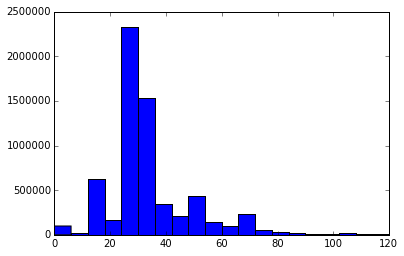

In [43]:
plt.hist(duration, range=(0, 120), bins=20)

# Row count distribution

(array([ 25.,  22.,  24.,  24.,  23.,  24.,  22.,  25.,  20.,  20.,  22.,
         24.,  22.,  16.,  22.,  10.,  25.,  22.,  25.,  21.,  23.,  25.,
         21.,  22.,  21.,  24.,  20.,  24.,  21.,  18.,  24.,  13.,  14.,
         16.,   5.,   4.,   2.,   0.,   1.,   0.]),
 array([    0.,    25.,    50.,    75.,   100.,   125.,   150.,   175.,
          200.,   225.,   250.,   275.,   300.,   325.,   350.,   375.,
          400.,   425.,   450.,   475.,   500.,   525.,   550.,   575.,
          600.,   625.,   650.,   675.,   700.,   725.,   750.,   775.,
          800.,   825.,   850.,   875.,   900.,   925.,   950.,   975.,
         1000.]),
 <a list of 40 Patch objects>)

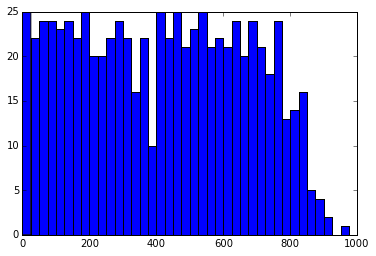

In [70]:
plt.hist(rc, range=(0,1000), bins=40)

In [117]:
query_data = ctx.sql('''select * from (
select 
        sum(cpu_time) as ctime,
        sum(row_count) as totalrows,
        sum(duration) as totalduration,
        count(*) as cc, 
        query_hash 
from srows
group by srows.query_hash
order by ctime desc
limit 4
) as temp_table
''')
query_data_list = query_data.collect()

In [128]:
ntuser_data = ctx.sql('''select * from (
select 
        sum(cpu_time) as ctime,
        sum(row_count) as totalrows,
        sum(duration) as totalduration,
        count(*) as cc, 
        nt_username
from srows
group by srows.nt_username
order by cc desc
limit 11
) as temp_table
''')
ntuser_data_list = ntuser_data.collect()

# Top 3 CPU time consuming queries

In [124]:
for i in query_data.collect():
    print '-' * 80
    print data.select('query_hash', 'statement').filter('query_hash = %s' % i.query_hash).take(1)[0].statement

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
SELECT [Ticket_Id] = [ID]
INTO #ticket_list
FROM [Encore_Ticketing_ODS].[dbo].[tickets] with (nolock)
WHERE [Encore_Ticketing_ODS].[dbo].[GET_TZTIME]([created_at],'ct') >= DATEADD(month, DATEDIFF(month, 0, getdate())-12, 0)

UNION

SELECT [Ticket_Id]
FROM [Encore_Ticketing_ODS].[dbo].[comments] with (nolock)
WHERE [Encore_Ticketing_ODS].[dbo].[GET_TZTIME]([created_at],'ct') >= DATEADD(month, DATEDIFF(month, 0, getdate())-12, 0)

UNION

SELECT [Ticket_Id]
FROM [Encore_Ticketing_ODS].[dbo].[value_changes] with (nolock)
WHERE CAST([field_name] AS VARCHAR) like '%Status%'
	  AND CAST([value] AS VARCHAR)='Closed'
	  AND [Encore_Ticketing_ODS].[dbo].[GET_TZTIME]([Value_Change_Date],'ct') >= DATEADD(month, DATEDIFF(month, 0, getdate())-12, 0)
--------------------------------------------------------------------------------
Select DIS

# Top 10 most active users

In [143]:
import math
filtered = filter(lambda x: x.nt_username != u'', ntuser_data_list)
counts = map(lambda x: math.log10(x.cc), filtered)

In [154]:
for index, data in enumerate(filtered, 1):
    print '%d:\t %s\t\t (%d)' % (index, data.nt_username, data.cc)

1:	 RACKSPACE\QlikView_Service		 (6265738)
2:	 EUR\londb06.svc		 (43172)
3:	 NT AUTHORITY\SYSTEM		 (2928)
4:	 RACKSPACE\rahu1923		 (2082)
5:	 RACKSPACE\char1994		 (1955)
6:	 RACKSPACE\kuma4944		 (1526)
7:	 RACKSPACE\EBI_ODS_PROD_svc		 (903)
8:	 RACKSPACE\EBI_REPL_SVC		 (707)
9:	 RACKSPACE\jordan.brown		 (349)
10:	 RACKSPACE\stev7977		 (31)


### Logarithmic scale!

<Container object of 10 artists>

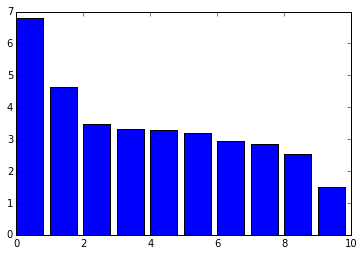

In [148]:
plt.bar(range(10), counts)